In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
# with tf.device(tf.DeviceSpec(device_type="GPU", device_index=gpu_id)):

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11363336457481470079
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2255906407
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9207222833155700439
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


### load data

In [3]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
num_classes = len(classes)

In [4]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


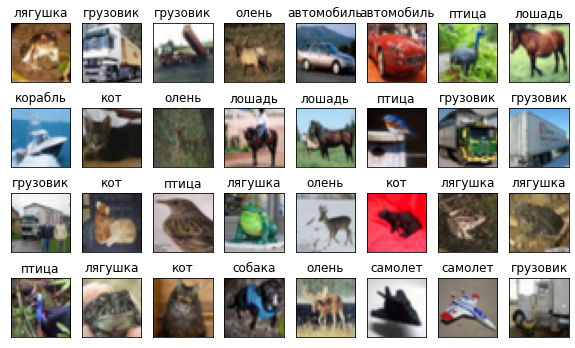

In [5]:
some_samples = x_train[:32, ...]
some_classes = y_train[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,:])
    plt.title(classes[np.argmax(some_classes[j,:])])
    plt.xticks([]), plt.yticks([])
plt.show()

### model building

In [6]:
batch_size = 64
epochs = 5

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=x_train.shape[0])
train_ds = train_ds.repeat(epochs)
train_ds = train_ds.batch(batch_size)

In [7]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
#         self.conv1 = tf.keras.layers.Conv2D(64, (7, 7), activation='relu', padding='same')
#         self.conv2 = tf.keras.layers.Conv2D(192, (5, 5), activation='relu', padding='same')
#         self.fc1 = tf.keras.layers.Dense(84, activation='relu')
#         self.fc2 = tf.keras.layers.Dense(10, activation=None)
#         self.max_pool = tf.keras.layers.MaxPooling2D((3, 3), (2, 2))
#         self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [8]:
model = Model()
model.build([None, 32, 32, 3])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  2432      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  51264     
_________________________________________________________________
dense (Dense)                multiple                  1048832   
_________________________________________________________________
dense_1 (Dense)              multiple                  2570      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
Total params: 1,105,098
Trainable params: 1,105,098
Non-trainable params: 0
___________________________________________________

In [9]:
def loss(logits, labels):
#     return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=tf.argmax(labels,1)))
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)
    return tf.reduce_mean(tf.reduce_sum(cross_entropy, axis=1))

def accuracy(logits, labels):
    predictions = tf.argmax(logits,1, tf.dtypes.int32)
    labels = tf.argmax(labels,1, tf.dtypes.int32)

    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype = tf.float32))

### model learning

In [10]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

writer = tf.summary.create_file_writer('logs/adam')

In [11]:
%%time

with tf.device('/device:GPU:0'):
    for iteration, (images, labels) in enumerate(train_ds):

        # Forward
        with tf.GradientTape() as tape:
            logits = model(images)
            
    #         print(logits)
            loss_value = loss(logits, labels)

        # Backward
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Calc and display loss/accuracy
        if iteration % 200 == 0:
            test_logits = model(x_test[:256, ...])
            accuracy_value = accuracy(test_logits, y_test[:256, ...])

            print("[%4d] Accuracy: %5.2f %%" % (
                iteration, accuracy_value.numpy()*100))

            with writer.as_default():
                tf.summary.scalar('accuracy', accuracy_value, iteration)
                tf.summary.scalar('loss', loss_value, iteration)

[   0] Accuracy:  9.38 %
[ 200] Accuracy: 42.19 %
[ 400] Accuracy: 50.39 %
[ 600] Accuracy: 53.52 %
[ 800] Accuracy: 54.69 %
[1000] Accuracy: 57.81 %
[1200] Accuracy: 57.81 %
[1400] Accuracy: 63.67 %
[1600] Accuracy: 67.19 %
[1800] Accuracy: 67.19 %
[2000] Accuracy: 61.33 %
[2200] Accuracy: 66.80 %
[2400] Accuracy: 69.53 %
[2600] Accuracy: 70.31 %
[2800] Accuracy: 69.92 %
[3000] Accuracy: 71.09 %
[3200] Accuracy: 74.22 %
[3400] Accuracy: 68.75 %
[3600] Accuracy: 73.44 %
[3800] Accuracy: 75.39 %
Wall time: 47.2 s


### accuracy check

In [12]:
%%time
with tf.device('/device:CPU:0'):
    test_logits = model(x_test)
    accuracy_value = accuracy(test_logits, y_test).numpy()
    print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))

Final Accuracy: 71.33 %
Wall time: 3.42 s


### prediction

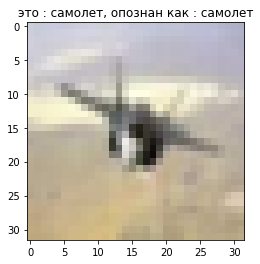

In [13]:
import random
N = random.randint(0, x_test.shape[0])

y_p=model.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[y_t[0]]+', опознан как : '+classes[y_i[0]])
plt.show()

### tensorboard

In [14]:
%reload_ext tensorboard

In [15]:
%tensorboard --logdir logs/adam

Reusing TensorBoard on port 6006 (pid 2244), started 0:05:41 ago. (Use '!kill 2244' to kill it.)